<a href="https://colab.research.google.com/github/DILSHAN565/FYP_DL_Models/blob/main/CNN_For_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow

In [2]:
import numpy as np

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
from tensorflow.keras.layers import Dense, Activation

In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Open In Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

# Define the path to the directory containing your dataset
directory_path = '/content/drive/My Drive/Tea-Leaf-Diseases-Dataset'

# List all files in the directory
files = os.listdir(directory_path)

# Print the list of files
print(files)

['train', 'validation', 'test']


In [9]:
# Install necessary packages
!pip -q install vit_keras tensorflow-addons
!pip -q install --upgrade --no-cache-dir gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.2 MB/s eta 0:00:00


In [10]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from vit_keras import vit
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
SEED = 42
np.random.seed(SEED)

In [12]:
# Insert the Dataset path here
train_path = '/content/drive/MyDrive/Tea-Leaf-Diseases-Dataset/train'
val_path = '/content/drive/MyDrive/Tea-Leaf-Diseases-Dataset/validation'
test_path = '/content/drive/MyDrive/Tea-Leaf-Diseases-Dataset/test'

In [13]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   brightness_range=[0.8, 1.4],
                                   vertical_flip=True,
                                   horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 566 images belonging to 8 classes.
Found 123 images belonging to 8 classes.
Found 124 images belonging to 8 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
# Define the model
model = Sequential()

In [17]:
# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

In [18]:
# Flatten the output before feeding into the fully connected layers
model.add(Flatten())

In [19]:
# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))  # 8 classes for tea leaf disease classification

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [21]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger


In [22]:
# Define the directory for saving model artifacts
save_dir = '/content/drive/MyDrive/For-Report/CNN-Modified'

# Ensure the base directory exists
os.makedirs(save_dir, exist_ok=True)

# Specific directory for saving weights
weights_dir = os.path.join(save_dir, 'weights')
os.makedirs(weights_dir, exist_ok=True)

# Directory for logging CSV data
logs_dir = os.path.join(save_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

In [23]:
# ModelCheckpoint: Save the best model weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(weights_dir, 'CNN_weights-{epoch:02d}.h5'),
    save_weights_only=True,
    monitor='val_loss',  # Change to 'val_loss' if you want to monitor validation loss instead
    mode='min',  # Use 'min' if monitoring 'val_loss'
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)

# CSVLogger: Log training data into a CSV file
csv_logger_callback = CSVLogger(
    os.path.join(logs_dir, 'training_log.csv')
)

# EarlyStopping: Stop training when a monitored metric has stopped improving
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

# Combine all callbacks
callbacks = [
    model_checkpoint_callback,
    reduce_lr_callback,
    csv_logger_callback,
    early_stopping_callback
]


In [25]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Now, you can use this `callbacks` list when fitting your model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 1.9639 - accuracy: 0.2309
Epoch 1: val_loss improved from inf to 1.82275, saving model to /content/drive/MyDrive/For-Report/CNN-Modified/weights/CNN_weights-01.h5
35/35 [==============================] - 353s 10s/step - loss: 1.9639 - accuracy: 0.2309 - val_loss: 1.8228 - val_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 1.6686 - accuracy: 0.3691
Epoch 2: val_loss improved from 1.82275 to 1.54978, saving model to /content/drive/MyDrive/For-Report/CNN-Modified/weights/CNN_weights-02.h5
35/35 [==============================] - 34s 978ms/step - loss: 1.6686 - accuracy: 0.3691 - val_loss: 1.5498 - val_accuracy: 0.3929 - lr: 1.0000e-04
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 1.4376 - accuracy: 0.4018
Epoch 3: val_loss improved from 1.54978 to 1.42275, saving model to /content/drive/MyDrive/For-Report/CNN-Modified/weights/CNN_weights-03.h5

In [27]:
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train_loss', 'val_loss'], loc='best')
    plt.show()

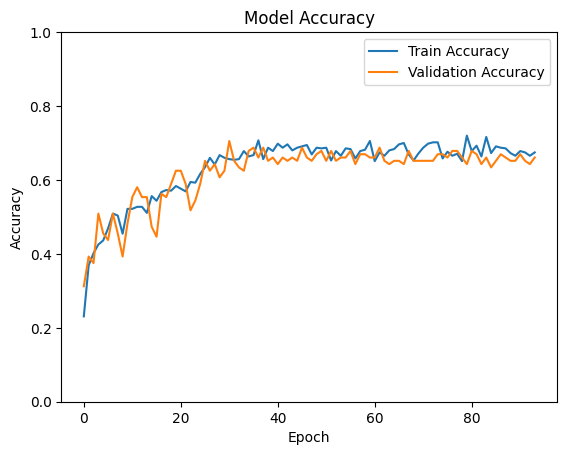

In [30]:
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])  # Replace with 'accuracy' if that's the key in your history
    plt.plot(history.history['val_accuracy'])  # Replace with 'val_accuracy' accordingly
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0, 1)
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
    plt.show()

# Call plot_accuracy with your history object
plot_accuracy(history, 'Model Accuracy')


In [ ]:

#model = create_model()
model.load_weights('/content/drive/MyDrive/For-Report/CNN-Modified/weights/CNN_weights-37.h5')


In [ ]:
# Assume the model.predict() call returns a predictions object
predictions = model.predict(test_generator, verbose=0)

# Getting the index of the highest probability class per image
y_pred = np.argmax(predictions, axis=1)

# Getting the true labels per image
y_true = test_generator.classes

# Getting the class names (labels) from the generator
class_names = list(test_generator.class_indices.keys())

# Printing the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

In [ ]:

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt# Compute confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using mlxtend's `plot_confusion_matrix`
figure, ax = plot_confusion_matrix(conf_mat=cm,
                                   show_absolute=True,
                                   show_normed=False,
                                   colorbar=True,
                                   class_names=class_names,
                                   figsize=(7, 7))
plt.show()